## Initialization

Run the following code to import the modules you'll need. After your finish the assignment, remember to run all cells and save the note book to your local machine as a PDF for gradescope submission.

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import platform
import random
from random import randrange
import time
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import glob
from skimage.util import montage

np.random.seed(0)

# 1. Setup dataset

In this section we will download the dataset, unzip it and setup the paths to load images from.

This dataset is a tiny subset of [ImageNet](https://www.image-net.org/), a popular dataset for image classification.

This tiny dataset has **9538 training** images and **3856 test** images spanning **10 classes** {*fish, English-springer, cassette-player, chain-saw, church, French-horn, garbage-truck, gas-pump, golf-ball, parachute*} stored in the following directory structure:
```
dataset
  ---train
     ---class1
     ---class2
     ...
  ---test
     ---class1
     ---class2
     ...       
```
The data has been cleaned and we have provided dataloading functions below so you can directly use the dataset.


In [ ]:
if not os.path.exists('imagenette'):
  #!wget "https://drive.google.com/uc?export=download&id=1t3XtxcpVwZnKhsM95Q89MxYNlX5mj6aJ&confirm=t" -O /content/imagenette.zip
  !wget https://www.cs.cmu.edu/~deva/data/imagenette.zip -O /content/imagenette.zip
  !unzip -qq "/content/imagenette.zip"

In [2]:
train_data_path = 'content/imagenette/imagenette/train'
test_data_path =  'content/imagenette/imagenette/test'
train_image_paths = [] #to store image paths in list
test_image_paths  = []
classes           = []

#Get all the paths from train_data_path and append image paths and class to to respective lists

for data_path in glob.glob(train_data_path + '/*'):
    classes.append(data_path.split('\\')[-1])
    train_image_paths.append(glob.glob(data_path + '/*'))

for data_path in glob.glob(test_data_path + '/*'):
    test_image_paths.append(glob.glob(data_path + '/*'))

train_image_paths = [path.replace("\\", "/") for path in sum(train_image_paths,[])]
random.shuffle(train_image_paths)
test_image_paths = [path.replace("\\", "/") for path in sum(test_image_paths,[])]
random.shuffle(test_image_paths)

idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

In [3]:
def LoadData(img_paths,img_size,class_to_idx):
  n = len(img_paths)
  Images = np.zeros((n,img_size,img_size,3),dtype='uint8')
  Labels = np.zeros(n)
  for i in range(n):
    path = img_paths[i]
    Images[i,:,:,:] = np.asarray(Image.open(path).resize((img_size,img_size)))
    print(path)
    Labels[i] = class_to_idx[path.split('/')[-2]]
  return Images, Labels

# Load images as size 32x32; you can try with img_size = 64 to check if it improves the accuracy
img_size = 32
Train_Images, Train_Labels = LoadData(train_image_paths, img_size, class_to_idx)
Test_Images,   Test_Labels = LoadData( test_image_paths, img_size, class_to_idx)


content/imagenette/imagenette/train/golf-ball/n03445777_6019.JPEG
content/imagenette/imagenette/train/church/n03028079_2455.JPEG
content/imagenette/imagenette/train/cassette-player/n02979186_7147.JPEG
content/imagenette/imagenette/train/chain-saw/n03000684_5899.JPEG
content/imagenette/imagenette/train/golf-ball/n03445777_5504.JPEG
content/imagenette/imagenette/train/fish/n01440764_5879.JPEG
content/imagenette/imagenette/train/cassette-player/n02979186_9688.JPEG
content/imagenette/imagenette/train/fish/n01440764_9697.JPEG
content/imagenette/imagenette/train/garbage-truck/n03417042_7653.JPEG
content/imagenette/imagenette/train/French-horn/n03394916_43837.JPEG
content/imagenette/imagenette/train/chain-saw/n03000684_6696.JPEG
content/imagenette/imagenette/train/garbage-truck/n03417042_23784.JPEG
content/imagenette/imagenette/train/chain-saw/n03000684_11228.JPEG
content/imagenette/imagenette/train/gas-pump/n03425413_15057.JPEG
content/imagenette/imagenette/train/fish/n01440764_6169.JPEG
con

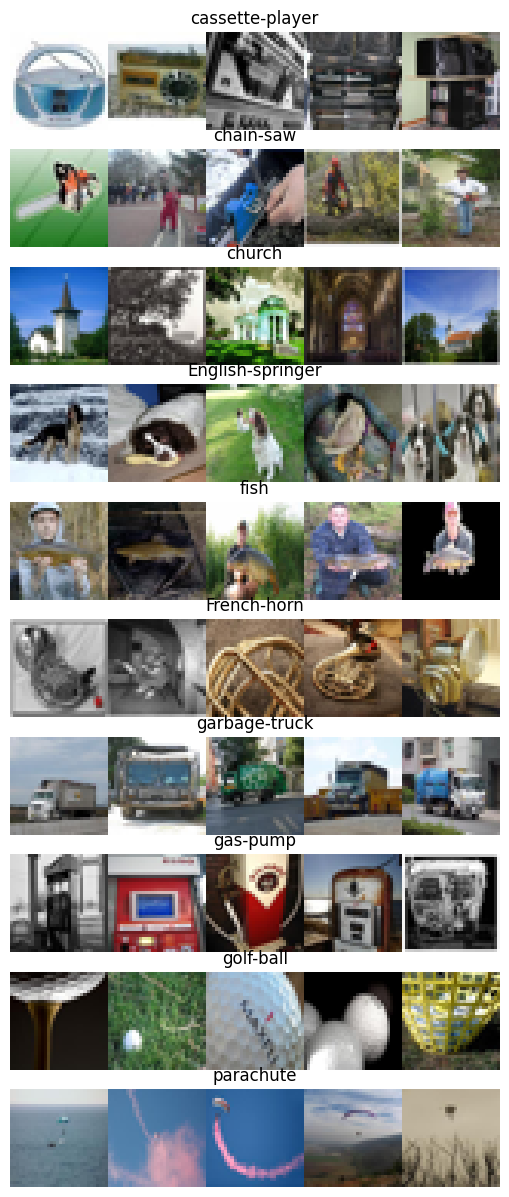

In [38]:
# Visualize the first 5 images of the 10 classes
plt.figure(figsize=(15,15))
for i in range(10):
  plt.subplot(10,1,i+1)
  ind = np.nonzero(Train_Labels == i)[0]
  plt.imshow(montage(Train_Images[ind[:5],:],grid_shape=(1,5),channel_axis=3))
  plt.axis('off')
  plt.title(idx_to_class[i])

## Debug Flag
Set the debug flag to true when testing.
Setting the debug flag to true will let the dataloader use only 20% of the training dataset, which makes everything run faster. This will make testing the code easier.

Once you finish the coding part please make sure to change the flag to False and rerun all the cells. This will make the colab ready for submission.

In [4]:
DEBUG = False

# Take a smaller subset of the training set for efficient execution of kNN
# We also create a small validation set

if DEBUG:
  num_train = 1900
  num_test =  700
else:
  num_train = 9000
  num_test =  3856

X_train = Train_Images[:num_train].reshape(num_train,-1).astype('float64')
y_train = Train_Labels[:num_train]
X_test  = Test_Images[:num_test].reshape(num_test,-1).astype('float64')
y_test  = Test_Labels[:num_test]

print('Train data shape: '  , X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Test data shape: '   , X_test.shape)
print('Test labels shape: ' , y_test.shape)


Train data shape:  (9000, 3072)
Train labels shape:  (9000,)
Test data shape:  (3856, 3072)
Test labels shape:  (3856,)


## **Problem 3.1**

### (a) Define the KNearestNeighbor class

In [5]:
from collections import Counter
class KNearestNeighbor(object):
  """ a kNN classifier with L2 distance """

  def __init__(self):
    pass

  def train(self, X, y):
    """
    Train the classifier. For k-nearest neighbors this is just
    memorizing the training data.
    Inputs:
    - X: A numpy array of shape (num_train, D) containing the training data
      consisting of num_train samples each of dimension D.
    - y: A numpy array of shape (N,) containing the training labels, where
         y[i] is the label for X[i].
    """
    self.X_train = X
    self.y_train = y

  def predict(self, X, k=1, num_loops=0):
    """
    Predict labels for test data using this classifier.
    Inputs:
    - X: A numpy array of shape (num_test, D) containing test data consisting
         of num_test samples each of dimension D.
    - k: The number of nearest neighbors that vote for the predicted labels.
    - num_loops: Determines which implementation to use to compute distances
      between training points and testing points.
    Returns:
    - y: A numpy array of shape (num_test,) containing predicted labels for the
      test data, where y[i] is the predicted label for the test point X[i].
    """
    if num_loops == 0:
      dists = self.compute_distances_no_loops(X)
    elif num_loops == 1:
      dists = self.compute_distances_one_loop(X)
    elif num_loops == 2:
      dists = self.compute_distances_two_loops(X)
    else:
      raise ValueError('Invalid value %d for num_loops' % num_loops)

    return self.predict_labels(dists, k=k)

  def compute_distances_two_loops(self, X):
    """
    Compute the l2 distance between each test point in X and each training point
    in self.X_train using a nested loop over both the training data and the
    test data.
    Inputs:
    - X: A numpy array of shape (num_test, D) containing test data.
    Returns:
    - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
      is the Euclidean distance between the ith test point and the jth training
      point.
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in range(num_test):
      for j in range(num_train):

        # ===== your code here! =====

        # TODO:
        # Compute the l2 distance between the ith test image and the jth
        # training image, and store the result in dists[i, j].

        dists[i,j] = np.linalg.norm(X[i] - self.X_train[j])

        # ==== end of code ====

    return dists

  def compute_distances_one_loop(self, X):
    """
    Compute the l2 distance between each test point in X and each training point
    in self.X_train using a single loop over the test data.
    Input / Output: Same as compute_distances_two_loops
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in range(num_test):
      
      # ===== your code here! =====

      # TODO:
      # Compute the l2 distance between the ith test point and all training
      # points, and store the result in dists[i, :].

      dists[i,:] = np.linalg.norm(X[i:i+1] - self.X_train, axis=1)

      # ==== end of code ====

    return dists

  def compute_distances_no_loops(self, X):
    """
    Compute the l2 distance between each test point in X and each training point
    in self.X_train using no explicit loops.
    Input / Output: Same as compute_distances_two_loops
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))

    # ===== your code here! =====

    # TODO:
    # Compute the l2 distance between all test points and all training
    # points without using any explicit loops, and store the result in
    # dists.
    #
    # You should implement this function using only basic array operations;
    # in particular you should not use functions from scipy.
    #
    # HINT: ||x - y||^2 = ||x||^2 + ||y||^2 - 2x y^T

    # ==== end of code ====
    dists = np.sqrt(np.linalg.norm(X, axis=1).reshape((-1,1))**2 + np.linalg.norm(self.X_train, axis=1).reshape((1,-1))**2 - 2*np.matmul(X, self.X_train.T))

    return dists

  def predict_labels(self, dists, k=1):
    """
    Given a matrix of distances between test points and training points,
    predict a label for each test point.
    Inputs:
    - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
      gives the distance betwen the ith test point and the jth training point.
    Returns:
    - y: A numpy array of shape (num_test,) containing predicted labels for the
      test data, where y[i] is the predicted label for the test point X[i].
    - knn_idxs: List of arrays, containing Indexes of the k nearest neighbors
      for the test data. So, for num_tests, it will be a list of length
      num_tests with each element of the list, an array of size 'k'. This will
      be used for visualization purposes later.
    """
    num_test = dists.shape[0]
    y_pred = np.zeros(num_test)
    knn_idxs = []
    for i in range(num_test):
      # A list of length k storing the labels of the k nearest neighbors to
      # the ith test point.

      closest_y = []

      # ===== your code here! =====

      # TODO:
      # Use the distance matrix to find the k nearest neighbors of the ith
      # testing element, and use self.y_train to find the labels of these
      # neighbors. Store these labels in closest_y.
      # Also, don't forget to apprpriately store indices knn_idxs list.
      # Hint: Look up the function numpy.argsort.

      closest_index = np.argsort(dists[i])[:k]
      closest_y = self.y_train[closest_index]
      knn_idxs.append(closest_y)

      # ==== end of code ====

      # Now that you have found the labels of the k nearest neighbors, the code
      # below finds the most common label in the list closest_y of labels.
      # and stores this label in y_pred[i]. We break ties by choosing the
      # smaller label.

      vote = Counter(closest_y)
      count = vote.most_common()
      y_pred[i] = count[0][0]

    return y_pred, knn_idxs

### (b) Check L2 distance implementation
Now, let's do some checks to see if you have implemented the functions correctly. We will first calculate distances using ***compute_distance_two_loops*** and check accuracy for k=1 and k=3.
Then, we will compare the ***compute_distance_one_loop*** and ***compute_distance_no_loop*** with  ***compute_distance_two_loops*** to ensure all results are consistent.

Initialize the KNN Classifier

In [6]:
classifier = KNearestNeighbor()
classifier.train(X_train,y_train)

Compute the distance between the training and test set.
This might take some time to run since we are running the two loops function which is not efficient.

**6 to 8 mins for full dataset | 2 to 3 mins for debug dataset**

In [199]:
dists_two = classifier.compute_distances_two_loops(X_test)

Now, let's do some checks to see if you have implemented the functions correctly. We will first calculate the distances using compute_distance_two_loops function and check the accuracies for k=1 and k=3.
Then, we will compare the compute_distance_one_loop and compute_distance_no_loop functions with it to check their correctness.


Predict labels and check accuracy for k = 1.
You should expect to see approximately 28% accuracy for full dataset.  
**(Accuracy below 24% on full dataset (Debug = False) will not be given full grades)**

In [200]:
y_test_pred, k_idxs  = classifier.predict_labels(dists_two, k=1)
# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 1088 / 3856 correct => accuracy: 0.282158


Now lets check the one loop implementation. This should also take some time to run.  
**4 to 6 mins for full dataset | 1 to 2 mins for debug dataset**

**Note:** This function can possibly take a little more time that two loop implementaion because of some quirks in python, numpy and cpu processing. It is fine as long as the final output shows no difference below.

In [201]:
# Implement the function compute_distances_one_loop in KNearestNeighbor class
# and run the code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.

difference = np.linalg.norm(dists_two - dists_one, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
  print('Good! The distance matrices are the same')
else:
  print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


Now lets check the vectorized implementation. This should take less than 30 secs to run for full dataset.

In [202]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_no = classifier.compute_distances_no_loops(X_test)
# check that the dist ance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists_two - dists_no, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
  print('Good! The distance matrices are the same')
else:
  print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


Let's compare how fast the implementations are
You should see significantly faster performance with the fully vectorized implementation

In [7]:
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops,X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop,X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops,X_test)
print('No loop version took %f seconds' % no_loop_time)

# you should see significantly faster performance with the fully vectorized implementation

Two loop version took 474.650016 seconds
One loop version took 1253.610741 seconds
No loop version took 4.031743 seconds


## From this point on, we will use the efficient no loop implementation

The given accuracy of 29% is much better than chance accuracy of

# ===== your answer here! =====

10% in case of a random guess of equal chance across our 10 categories, $probability = \frac{1}{10}$.

# ===== end of your answer =====


Though the no-loop impementation is far faster, there maybe situations where one_loop or two_loop implementations are useful, such as [HINT: Imagine really large training set and or testset]

# ===== your answer here! =====

when we have really large datasets in which we might end up out of memory for the distance matrix as we need to have in-memory the whole matrix as we perform the multiplication. In those cases we might have to do it in smaller batches for example per lines with the 1 loop formula. 

One way to improve time in this situations is by parallel programing in which each PE could calculate one row with a direct vectorize matrix multiplication (as for each row we need less memory) and then joining the results at the end. Although, I would only use this approach for very large matrices, as distributing different information to each processing element (PE) and having a manager combine the results introduces additional time overhead.

# ===== end of your answer =====


In [9]:
y_test_pred, k_idxs  = classifier.predict_labels(dists_no, k=3)
# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 1132 / 3856 correct => accuracy: 0.293568


### Visualize KNN results

Let's visualize the K nearest images for some randomly selected examples from the test set using the k_idxs list you returned in predict_labels.  

Here the leftmost column is the input image from the test set and rest of the
columns are the K nearest neighbors from the training set

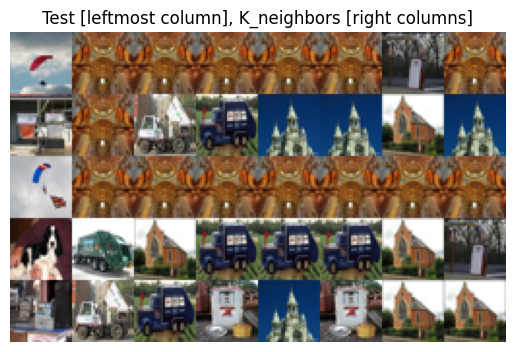

In [11]:
def visualize_knn(classifier,X_test,N=5, K=7):
  # This visualization routine makes use of GLOBAL Train_Images and Test_Images variables
  # to visualize the K nearest neighbors of the first N Test Images

  dist = classifier.compute_distances_no_loops(X_test[:N,:])
  _, k_idxs = classifier.predict_labels(dist,k=K)
  k_idxs  = np.vstack(k_idxs).astype(int)
  testim  = montage(Test_Images[:N,:],grid_shape=(N,1),channel_axis=3)
  trainim = montage(Train_Images[k_idxs.ravel(),:],grid_shape=(N,K),channel_axis=3)
  plt.imshow(np.concatenate((testim,trainim),axis=1))
  plt.axis('off');
  plt.title('Test [leftmost column], K_neighbors [right columns]')

visualize_knn(classifier,X_test)



### Normalizing image descriptors:

Let us try normalizing each image here by subtracting by its mean and scaling to have unit norm.

In [6]:
# Normalize each image descriptor to have zero-mean and unit-length

X_train_norm = X_train
X_test_norm  = X_test

# ===== your code here! =====
# Normalize each image descriptor to have zero-mean and unit-length
# If X is the descriptor vector for a given image, then sum_i X[i] = 0 and sum_i X[i]**2 = 1

def normalize(X):
  new_X = (X - X.mean(axis=1, keepdims=True))
  return new_X / np.linalg.norm(new_X, axis=1, keepdims=True)

X_train_norm = normalize(X_train_norm) 
X_test_norm  = normalize(X_test_norm)

# ===== end of code =====

print('Train data shape: ', X_train_norm.shape)
print('Test data shape: ', X_test_norm.shape)

Train data shape:  (9000, 3072)
Test data shape:  (3856, 3072)


We calculate the accuracies again using k = 1 and k = 3 and see that the accuracies are much better compared to those we obtained without any preprocessing on the images!

In [13]:
classifier = KNearestNeighbor()
classifier.train(X_train_norm,y_train)

# Classify using the efficient no_loops implementation
dists = classifier.compute_distances_no_loops(X_test_norm)

for k in [1, 3]:
    y_test_pred, k_labels = classifier.predict_labels(dists, k=k)

    # Compute and print the fraction of correctly predicted examples
    num_correct = np.sum(y_test_pred == y_test)
    accuracy = float(num_correct) / num_test
    print(f'[k = {k}]\nGot {num_correct} / {num_test} correct => accuracy: {accuracy}\n')

[k = 1]
Got 1272 / 3856 correct => accuracy: 0.32987551867219916

[k = 3]
Got 1311 / 3856 correct => accuracy: 0.3399896265560166



Written question: Normalization produces image descriptors that have unit length. Prove that minimizing the euclidean distance of such descriptors is equivalent to maximizing the cosine similarity. Here is an example of latex in markdown that might be helpful: $||x - y||^2 = x^Tx - 2x^Ty + y^Ty$    


===== your answer here! =====

In this case we have $||x|| = ||y|| = 1$ for all $x, y$. Then, minimize

$$f(x,y) = ||x - y||^2 = ||x||^2 + ||y||^2 - 2x^Ty = 1 + 1 - 2x^Ty = 2 - 2x^Ty$$

is the same as minimize $f_2(x,y) = -x^Ty$, same as maximize $f_3(x,y) = x^Ty$. But

$$f_3(x,y) = x^Ty = ||x||\ ||y||\ \cos(\alpha) = 1 \cdot 1 \cdot \cos(\alpha) = \cos(\alpha)$$

being $\alpha$ the angle between $x$ and $y$. Proving that minimizing the euclidean distance of such descriptors is equivalent to maximizing the cosine similarity between both descriptors.

===== end of your answer =====


## KNN with HOG
The previous parts all directly used raw pixels from input images to compute distances with k-NN. In this part, we will first use the Histogram of Oriented Gradients (HOG) as features for each image. We will use these features with our kNN implementation to find the nearest neighbours. Please read the descriptions and fill in the functions below.

In [7]:
def compute_gradient(image):
  """
    Computes the gradients in both x and y directions.
    Computes the magnitudes of the gradients.
    Computes the angles from the gradients and map to range [0, 180 deg].
    NOTE: You may *NOT* use np.gradient
    Inputs:
    - image: A (32,32) numpy array corresponding to a grayscale image
             or a (32,32,3) array corresponding to a color image
    Returns:
    - magnitudes: A numpy array of shape (32, 32) where magnitudes[i, j]
      is the magnitude of the gradient at the (i, j) pixel in the input image.
    - angles: A numpy array of shape (32, 32) where angles[i, j]
      is the angle of the gradient at the (i, j) pixel in the input image.
    HINT: First write thefunction assuming a grayscale input and get a final accuracy. Then write the color version.
          You may wish to use numpy.take_along_axis()
    """

  # ===== your code here! =====

  # TODO:
  # Compute the gradients along the rows and columns as two arrays.
  # Compute the magnitude as the square root of the sum of the squares of both gradients
  # Compute the angles as the inverse tangent of the gradients along the rows and
  # the gradients along the columns, and map them to the range [0, 180 deg]

  # Handle color image by converting to grayscale
  if image.ndim == 3:
      image = np.mean(image, axis=2)  # Convert to grayscale by averaging channels
  # another option is to maintain the 3D image and get the gradients from of the channels and the get the max gradient for each pixel at the end

  # Compute gradients along x (columns) and y (rows) directions
  gx = np.zeros_like(image)
  gy = np.zeros_like(image)

  # This is the same as using a kernel of [-1,0,1]
  gx[:, 1:-1] = image[:, 2:] - image[:, :-2]  # Gradient in x-direction  
  gy[1:-1, :] = image[2:, :] - image[:-2, :]  # Gradient in y-direction

  # Compute gradient magnitude
  magnitudes = np.sqrt(gx**2 + gy**2)

  # Compute gradient angles (in degrees)
  angles = np.arctan2(gy, gx) * (180 / np.pi)  # Convert from radians to degrees
  angles = np.mod(angles, 180)  # Map to [0, 180) range

  # ==== end of code ====
  return magnitudes, angles

In [8]:
def bin_gradient(angles, magnitudes, n_orient, pixels_per_cell):
  """
  Given the gradient orientations and magnitudes of an image, creates
  a histogram of orientations weighted by gradient magnitudes
  Inputs:
  - angles: A numpy array of shape (32, 32) where angles[i,j]
      is the angle of the gradient at the (i,j) pixel in the input image.
  - magnitudes: A numpy array of shape (32, 32) where magnitudes[i,j]
      is the magnitude of the gradient at the (i,j) pixel in the input image.
  - n_orient: An int representing the number of orientations to bin in histogram
  - pixels_per_cell: An int representing the number of rows/columns of pixels
      in each spatial cell
  Returns:
  - oriented_histogram: A numpy array of shape (32/4=8, 32/4=8,9)
      for pixels_per_cell=4 and n_orient=9
   """

  n_y,n_x = angles.shape
  oriented_histogram = np.zeros((int(n_y//pixels_per_cell),int(n_x//pixels_per_cell),n_orient))

  # ===== your code here! =====

  # TODO:
  # Iterate through each pixel in every cell
  # Find the index to the bin in histogram for that pixel's orientation
  # Add the weighted magnitude to the corresponding bins in the histogram

  sy, sx, _ = oriented_histogram.shape
  for i in range(sy):
    for j in range(sx):
      # get all the angles in integer cells between [0, n_orient-1]
      # the 180.125 is just to make sure that the angle "180" goes to the "n_orient - 1" cell after "np.floor" instead of the cell "n_orient"
      levels = np.floor(angles[i*pixels_per_cell : (i+1)*pixels_per_cell, j*pixels_per_cell : (j+1)*pixels_per_cell].flatten() / 180.125 * n_orient).astype(int)
      # get all the magnitudes in the same format for future weight addition to the histogram
      weights = magnitudes[i*pixels_per_cell : (i+1)*pixels_per_cell, j*pixels_per_cell : (j+1)*pixels_per_cell].flatten()
      oriented_histogram[i,j,:] = np.bincount(levels, weights=weights, minlength=n_orient)

  # ==== end of code ====
  return oriented_histogram


## Custom function to plot the oriented histogram in 2d

This section is extra but I found interesting how to plot this HOG images. Basically the idea is divide the image in small blocks of size $(pixels\_per\_cell \times pixels\_per\_cell)$. In each of those blocks we create a histogram (of $n\_orient$ bins) and plot those directions with the intensity based on the weight of each direction. At the end of the proccess we find a black-white image representing its edges, really interesting.

Of course **sklearn** already provides this feauture so I'm goin to create a custom one. But first we are going to see the results from sklearn.

#### Checking sklearn version

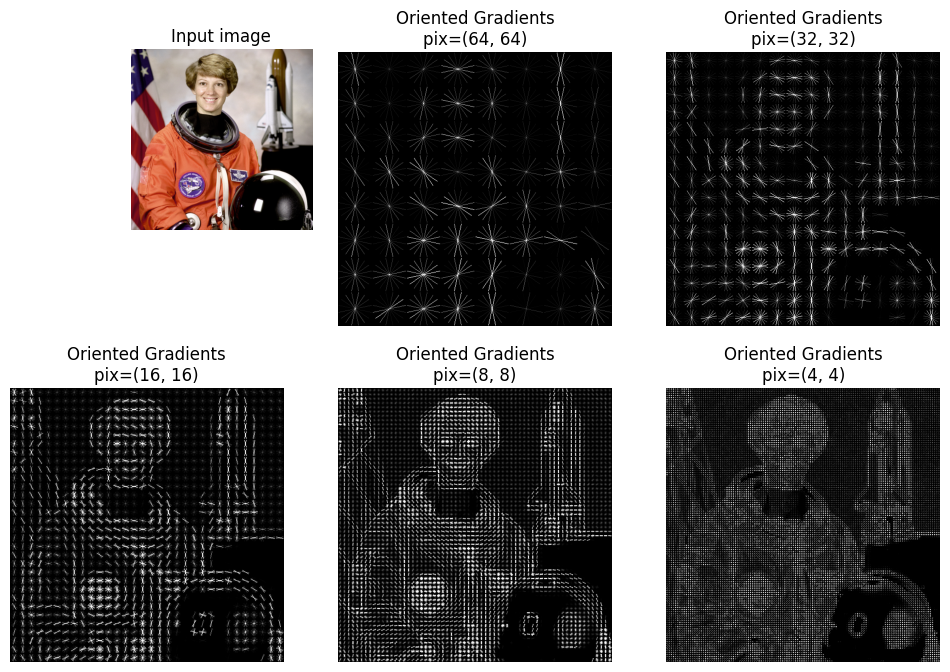

In [22]:
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import data, exposure

# Load an example image
image = data.astronaut() # X_train[0].reshape(32,32,3).astype("uint8") # data.astronaut()

# Compute HOG features

plt.figure(figsize=(12,8))  

i = 0
for p in [64, 32, 16, 8, 4]:
    pixels_per_cell = (p,p)
    fd, hog_image = hog(image, orientations=8, pixels_per_cell=pixels_per_cell,
                        cells_per_block=(1, 1), visualize=True, channel_axis=-1)
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    i += 1
    plt.subplot(2, 3, i+1)

    plt.axis('off')
    plt.imshow(hog_image_rescaled, cmap=plt.cm.gray)
    plt.title(f'Oriented Gradients\npix={pixels_per_cell}')

plt.subplot(3, 2, 1)
plt.axis('off')
plt.imshow(image, cmap=plt.cm.gray)
plt.title('Input image')

plt.show()

#### Custom version

In [173]:
from myhog import myhog, myhog2   # custom functions made at "myhog.py"

In [ ]:
img = data.astronaut()
myhog(img, n_orient=5, pixels_per_cell=16)
myhog2(img, n_orient=5, pixels_per_cell=16)

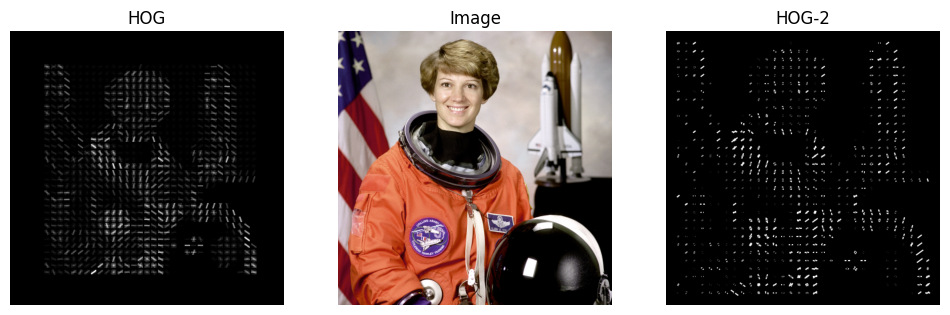

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.axis("off")
plt.title("HOG")
plt.imshow(plt.imread("hog.png"))
plt.subplot(1,3,2)
plt.axis("off")
plt.title("Image")
plt.imshow(img)
plt.subplot(1,3,3)
plt.axis("off")
plt.title("HOG-2")
plt.imshow(plt.imread("hog2.png"))
plt.show()

HOG is what we were looking for. Although HOG-2 has the same inner matrix is just the way I decided to plot it for personal experimentation.

HOG is based on alpha weighted by the intensity of the angle while HOG-2 is colored by a gray-scale map depending on the weighted angle as well. HOG looks cleaner.

Also we can plot in 3d the image to see the effect of the gradients, how the difference in colors really makes a descending / ascending gradient in the 3d world of the image, very insightful for tracking edges. 

*To see the interactive 3d plot and be able to move it and see the image uncomment the first line*

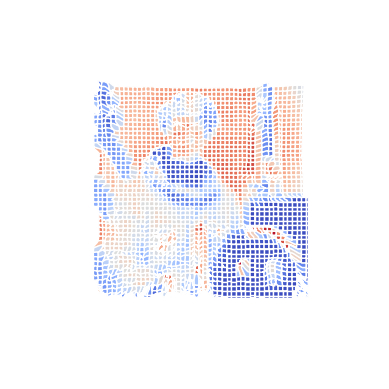

In [31]:
# %matplotlib tk

Nx, Ny, _ = img.shape
x, y = np.meshgrid(np.arange(Nx), np.arange(Ny))

gray_img = np.mean(img, axis=2)

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
plt.axis("off")
ax.plot_surface(x, y, gray_img, cmap="coolwarm")
ax.view_init(azim=-90, elev=-90)
plt.show()

**NOTE :** Once we create a histogram based on the gradient of the image we need to normalize it. Gradients of an image are sensitive to overall lighting. If you make the image darker by dividing all pixel values by 2, the gradient magnitude will change by half, and therefore the histogram values will change by half.

Ideally, we want our image features to be independent of lighting variations. In other words, we would like to “normalize” the histogram so they are not affected by lighting variations.

We have provided the normalization code below.

In [9]:
def block_normalize(oriented_histogram, cells_per_block, clip = True, epsilon=1e-5):
  """
  Normalizes the histogram in blocks of size cells_per_block.
  Inputs:
  - oriented_histogram: A numpy array of shape (num_cell_rows, num_cell_cols, num_orient)
    representing the histogram of oriented gradients of the input image.
  - cells_per_block: An int representing the number of rows/columns of cells that
    should together be normalized in the same block (you can assume )
  - clip: If true, this clips the normalized descriptor of each block to ensure that no values are larger than .2 (and then
    renormalizes to ensure the clipped descriptor is unit-norm), just as SIFT does
  - epsilon: A float indicating the small amount added to the denominator when
    normalizing to avoid dividing by zero.
  Returns:
  - normalized_blocks: A numpy array of shape 
    (n_blocks_y, n_blocks_x, cells_per_block, cells_per_block, num_orient),
    where normalized_blocks[i, j] is a normalized "SIFT" descriptor.
  """
  # Number of blocks along the y and x dimensions
  n_blocks_y = oriented_histogram.shape[0] - cells_per_block + 1
  n_blocks_x = oriented_histogram.shape[1] - cells_per_block + 1
  
  # ===== your code here! =====

  # TODO:
  # While there are many ways to compute the descriptor, we suggest iterating through the first dimension (n_blocks_y)
  # and second dimension (n_blocks_x) of normalized blocks and compute the [4 4 9] "SIFT" descriptor
  # (assuming cells_per_block = 4 and n_orient = 9).

  # Initialize normalized_blocks
  num_orient = oriented_histogram.shape[2]
  normalized_blocks = np.zeros((n_blocks_y, n_blocks_x, cells_per_block, cells_per_block, num_orient))

  # Iterate through blocks
  for y in range(n_blocks_y):
      for x in range(n_blocks_x):
        # Extract the block
        block = oriented_histogram[y:y+cells_per_block, x:x+cells_per_block, :]
        # Flatten the block into a 1D vector
        block_vector = block.ravel()

        # Normalize the block
        norm = np.sqrt(np.sum(block_vector ** 2) + epsilon)
        normalized_vector = block_vector / norm
          
        # Clip if necessary
        if clip:
            normalized_vector = np.clip(normalized_vector, 0, 0.2)
            # Renormalize after clipping
            norm_after_clip = np.sqrt(np.sum(normalized_vector ** 2) + epsilon)
            normalized_vector = normalized_vector / norm_after_clip

        # Reshape back to block shape and store in the result
        normalized_blocks[y, x] = normalized_vector.reshape((cells_per_block, cells_per_block, num_orient))

  return normalized_blocks


After implementing your HOG functions, please run the cells below to test the results. You should expect to get an accuracy slightly higher than that with unnormalized raw pixels.

In [11]:
def compute_hog(image,n_orient=9,pixels_per_cell=4,cells_per_block=4, return_type="ravel"):
  """
  Builds a Histogram of Oriented Gradients (HOG) weighted by gradient magnitudes
  from an input image
  Inputs:
  - image: A numpy array of shape (32, 32) containing one grayscaled image.
  Outputs:
  - histogram: A 1D numpy array that represents the HOG descriptor for the image.
  """
  assert(image.dtype == 'float64')
  # Read in image and convert to grayscale
  # if len(image.shape) > 2:
  #  image = np.mean(image,2)

  # Compute gradient
  magnitudes, angles = compute_gradient(image)

  # Bin gradients into cells
  oriented_histogram = bin_gradient(angles, magnitudes, n_orient, pixels_per_cell)

  # Block normalize the cells
  normalized_blocks = block_normalize(oriented_histogram, cells_per_block)

  # Return flattened descriptor (without making an additional copy)
  if return_type == "ravel":
    return normalized_blocks.ravel()
  # Return plain descriptor
  return normalized_blocks

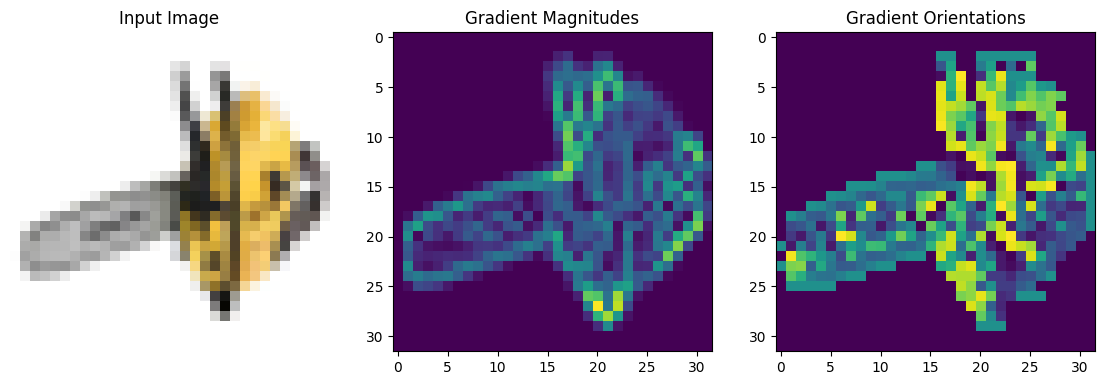

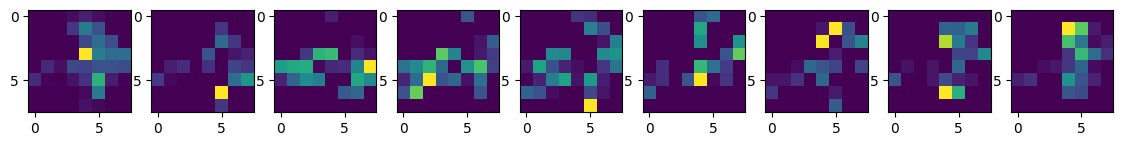

In [221]:
# Check out HOG descriptor for a single image
#image = X_train[0].mean(2) # Initially, build representation for grayscale image
image = X_train[5].reshape(img_size,img_size,3)
plt.figure(figsize=(14,8))
plt.subplot(1,3,1)
plt.imshow(image.astype('uint8'));
plt.axis('off')
plt.title('Input Image')

pixels_per_cell=4
cells_per_block=4
n_orient=9
angle_step = 180 // n_orient

# Step 1: compute gradients
magnitudes, angles = compute_gradient(image)

plt.subplot(1,3,2)
plt.imshow(magnitudes)
plt.title('Gradient Magnitudes')

plt.subplot(1,3,3)
plt.imshow(angles)
plt.title('Gradient Orientations')


# Step 2: Bin gradients into cells
oriented_histogram = bin_gradient(angles, magnitudes, n_orient, pixels_per_cell)
plt.figure(figsize=(14,8))
#plt.suptitle('Oriented Histograms')
for i in range(n_orient):
  plt.subplot(1,n_orient,i+1)
  plt.imshow(oriented_histogram[:,:,i])

# Step 3: Block normalize the cells
normalized_blocks = block_normalize(oriented_histogram, cells_per_block)


This part will take some time to run for the full dataset. Approx 1 to 2mins.

In [40]:
X_train_hog = np.array([compute_hog(X_train[i].reshape(img_size,img_size,3)) for i in range(num_train)])
X_test_hog  = np.array([compute_hog( X_test[i].reshape(img_size,img_size,3)) for i in range(num_test)])
print('Train data shape: ', X_train_hog.shape)
print('Test data shape: ' , X_test_hog.shape)

Train data shape:  (9000, 3600)
Test data shape:  (3856, 3600)


In [40]:
classifier = KNearestNeighbor()
classifier.train(X_train_hog,y_train)
dists = classifier.compute_distances_no_loops(X_test_hog)

Here the results were only for $k=3$ but I wanted to add some additional values to compare results.

In [214]:
# Compute and print the fraction of correctly predicted examples
import pandas as pd

results = {"k":[], "correct":[], "accuracy":[]}
print("Number of test:", num_test)
for k in range(1,11):
    y_test_pred, k_labels  = classifier.predict_labels(dists, k=k)
    num_correct = np.sum(y_test_pred == y_test)
    accuracy = float(num_correct) / num_test
    results["k"].append(k)
    results["correct"].append(num_correct)
    results["accuracy"].append(round(accuracy, 4))
pd.DataFrame(results)

Number of test: 3856


,k,correct,accuracy
0,1,1417,0.3675
1,2,1417,0.3675
2,3,1491,0.3867
3,4,1537,0.3986
4,5,1574,0.4082
5,6,1595,0.4136
6,7,1617,0.4193
7,8,1630,0.4227
8,9,1630,0.4227
9,10,1631,0.4230


For $k=3$ we got a 38% acurracy which a really good improvement given the previous 29% without the hog features.

You can also visualize the K nearest images for some randomly selected examples from the test set using the k_idxs list you returned in predict_labels trained with HOG descriptors.

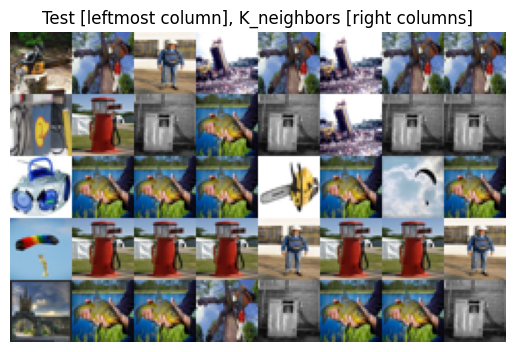

In [215]:
visualize_knn(classifier,X_test_hog)

### Extra credit 1: parameter tweaking
Add in descriptions of your optimal parameter settings and the resulting performance, compared to your default parameter settings and your default performance


 # ===== your answers here! =====

In order to came up with the best parameters I'm going to do a small custom gridsearch within some of our hyperparameters.

First I'll define a function **gridSearch()** to calculate the accuracy of all the given combinations and return a dataframe with all the metrics.

In [ ]:
def gridSearch(n_orients, ps, ks):

    results = {"k":[], "n_orient":[], "pixels_per_cell":[], "cells_per_block":[], "correct":[], "accuracy":[]}

    for n_orient in n_orients:
        for p in ps:
            
            pixels_per_cell, cells_per_block = 2**p, 2**p   # has to be divisor of 32 [2, 4, 8, ...] more than 8 is to big for a 32x32 image
            
            # create training with this settings
            X_train_hog = np.array([
                    compute_hog(X_train[i].reshape(img_size,img_size,3), n_orient=n_orient, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block) 
                for i in range(num_train)])
            X_test_hog  = np.array([
                    compute_hog( X_test[i].reshape(img_size,img_size,3), n_orient=n_orient, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block) 
                for i in range(num_test)])

            # create and train KNN
            classifier = KNearestNeighbor()
            classifier.train(X_train_hog,y_train)
            dists = classifier.compute_distances_no_loops(X_test_hog)

            # check results
            for k in ks:
                y_test_pred, k_labels  = classifier.predict_labels(dists, k=k)
                num_correct = np.sum(y_test_pred == y_test)
                accuracy = float(num_correct) / num_test
                results["n_orient"].append(n_orient)
                results["pixels_per_cell"].append(pixels_per_cell)
                results["cells_per_block"].append(cells_per_block)
                results["k"].append(k)
                results["correct"].append(num_correct)
                results["accuracy"].append(round(accuracy, 4))

    return pd.DataFrame(results)
            

In [227]:
df = gridSearch(n_orients=[3,5,9], ps=[1,2], ks=[3,7,11])
df.sort_values(by="accuracy", ascending=False)

,k,n_orient,pixels_per_cell,cells_per_block,correct,accuracy
17,11,9,4,4,1649,0.4276
16,7,9,4,4,1617,0.4193
11,11,5,4,4,1612,0.4180
10,7,5,4,4,1585,0.4110
15,3,9,4,4,1491,0.3867
5,11,3,4,4,1434,0.3719
9,3,5,4,4,1412,0.3662
4,7,3,4,4,1366,0.3543
8,11,5,2,2,1361,0.3530
3,3,3,4,4,1279,0.3317


As we can see, seems like pixels per cell / cell per block = 4 wins by far, this meens just looking to 2x2 blocks in not very insightful for the model, on the other side going further to 8 is not possible given the small size of the image 32x32. 

On the other side we observe improvement as k and n_orient increases. Thus, given this results we are going to continue our search with this two hyperparameters.  

In [229]:
df2 = gridSearch(n_orients=[9, 11, 13, 15], ps=[2], ks=[7, 11, 15, 21])
df2.sort_values(by="accuracy", ascending=False)

,k,n_orient,pixels_per_cell,cells_per_block,correct,accuracy
3,21,9,4,4,1677,0.4349
11,21,13,4,4,1673,0.4339
10,15,13,4,4,1671,0.4334
7,21,11,4,4,1667,0.4323
15,21,15,4,4,1660,0.4305
9,11,13,4,4,1651,0.4282
2,15,9,4,4,1650,0.4279
1,11,9,4,4,1649,0.4276
6,15,11,4,4,1648,0.4274
5,11,11,4,4,1642,0.4258


C:\Users\javie\AppData\Local\Temp\ipykernel_6652\3517435951.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot([3,7,11], df[df["cells_per_block"] == 4][df["n_orient"] == n].sort_values(by="accuracy")["accuracy"], "--", color=c, label=f"n_orient = {n}")
C:\Users\javie\AppData\Local\Temp\ipykernel_6652\3517435951.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot([3,7,11], df[df["cells_per_block"] == 4][df["n_orient"] == n].sort_values(by="accuracy")["accuracy"], "--", color=c, label=f"n_orient = {n}")
C:\Users\javie\AppData\Local\Temp\ipykernel_6652\3517435951.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot([3,7,11], df[df["cells_per_block"] == 4][df["n_orient"] == n].sort_values(by="accuracy")["accuracy"], "--", color=c, label=f"n_orient = {n}")


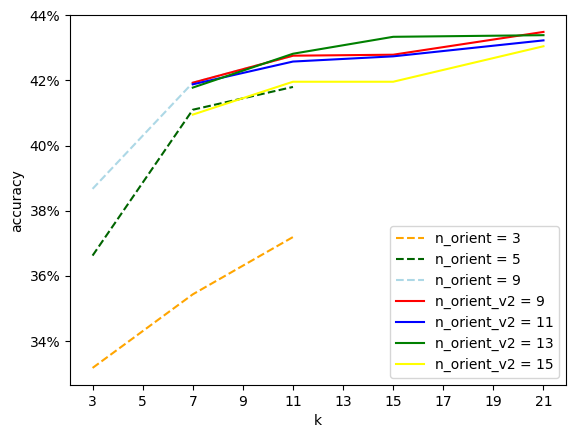

In [246]:
for c, n in zip(["orange", "darkgreen", "lightblue"], [3, 5, 9]):
    plt.plot([3,7,11], df[df["cells_per_block"] == 4][df["n_orient"] == n].sort_values(by="accuracy")["accuracy"], "--", color=c, label=f"n_orient = {n}")

for c, n in zip(["red", "blue", "green", "yellow"], [9, 11, 13, 15]):
    plt.plot([7, 11, 15, 21], df2[df2["n_orient"] == n].sort_values(by="accuracy")["accuracy"], color=c, label=f"n_orient_v2 = {n}")

plt.legend()
plt.xlabel("k")
plt.ylabel("accuracy")
plt.xticks(range(3,22,2))
plt.yticks(np.arange(34, 45, 2) / 100., labels=[f"{n}%" for n in range(34, 45, 2)])
plt.show()

We can observe huge improvement from 3 to 9 orientations, but once we keep incresing that number, we barely improve. That's something that clearly we could have guessed before any results as the human eye (and therefore the model) can't distingüis more than X orientations. Basically we want to know if is incline / horizontal / vertical with some extra detail in which I found reasonable, given the results, to keep at n_orient=9.

With that being said I'm going to do a final analysis for only n_orient=9 and different $k$ values. Although we have to have in mind that the higher the $k$ the higher the cost of compute the model so we will try to get a reasonable one given the final results.

In [248]:
df3 = gridSearch(n_orients=[9], ps=[2], ks=range(3, 40, 2))
df3.sort_values(by="accuracy", ascending=False)

,k,n_orient,pixels_per_cell,cells_per_block,correct,accuracy
10,23,9,4,4,1689,0.4380
9,21,9,4,4,1677,0.4349
14,31,9,4,4,1676,0.4346
18,39,9,4,4,1671,0.4334
15,33,9,4,4,1670,0.4331
17,37,9,4,4,1669,0.4328
13,29,9,4,4,1668,0.4326
5,13,9,4,4,1664,0.4315
11,25,9,4,4,1662,0.4310
16,35,9,4,4,1661,0.4308


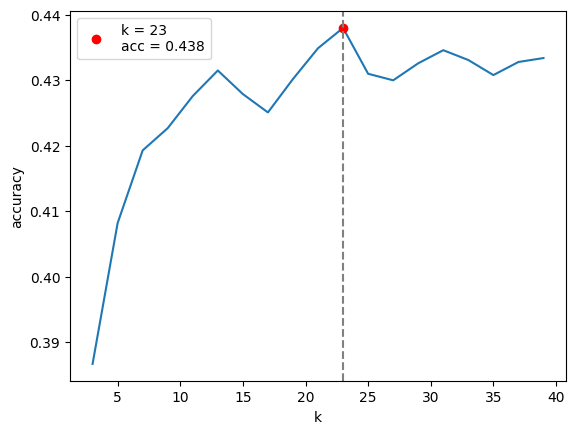

In [272]:
plt.plot(range(3, 40, 2), df3.sort_values(by="k")["accuracy"])
maxrow = df3[df3["accuracy"] == df3["accuracy"].max()]
plt.plot(maxrow["k"], maxrow["accuracy"], "ro", label=f"k = {maxrow["k"].item()}\nacc = {maxrow["accuracy"].item()}")
plt.axvline(x=maxrow["k"].item(), linestyle="--", color="gray")
plt.xlabel("k")
plt.ylabel("accuracy")
plt.legend()
plt.show()

After a final research around $k$, we see that is not worth increase $k$ more than 23. Thus, the best hyperparameter combination is:

BEST MODEL
---

| **Parameter**             | **Value** |
|---------------------------|-----------|
| Number of orientations    | 9         |
| Pixels per cell           | 4         |
| Cells per block           | 4         |
| Number of neighbors       | 21        |

**accuracy = 43.8 %**

Also a less costly model and with very similar results would be to chose $k=13$ almost half of our optimal value but at the same time keeping almost the same accuracy:



LIGHT MODEL
---

| **Parameter**             | **Value** |
|---------------------------|-----------|
| Number of orientations    | 9         |
| Pixels per cell           | 4         |
| Cells per block           | 4         |
| Number of neighbors       | 13        |

**accuracy = 43.2 %**

 # ===== end answers here! =====

### Extra credit 2: low-rank descriptors

In this section, I will explore various methods of inputting the image, including RGB, grayscale, normalization, Histogram of Oriented Gradients (HOG), and dimensionality reduction. We'll compare the results of each approach to draw a conclusion.

First, I will generate some grayscale image data for future comparisons:

In [14]:
X_train_gray = Train_Images.mean(axis=3)[:num_train].reshape(num_train, -1)
X_test_gray = Test_Images.mean(axis=3)[:num_test].reshape(num_test, -1)

In [15]:
X_train_gray_norm = normalize(X_train_gray)
X_test_gray_norm = normalize(X_test_gray)

Next, I will apply a few dimensionality reduction methods to transform the data accordingly.

### **PCA for Dimensionality Reduction**  

To start, I will train a PCA model as a basic dimensionality reduction approach, examine the explained variance, and plot the results.

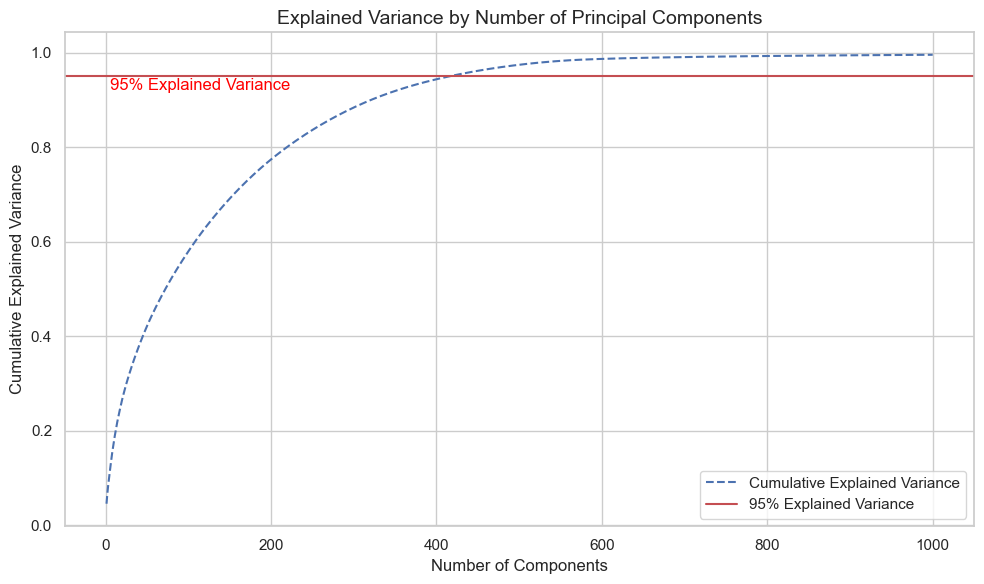

In [32]:
from sklearn.decomposition import PCA

# select 1000 and check the explained variance for optimal number
pca = PCA(n_components=1000)
pca.fit(X_train_hog)

# Calculate cumulative explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, linestyle='--', color='b', label='Cumulative Explained Variance')
plt.xlabel('Number of Components', fontsize=12)
plt.ylabel('Cumulative Explained Variance', fontsize=12)
plt.title('Explained Variance by Number of Principal Components', fontsize=14)

# Add a horizontal line for 95% variance
plt.axhline(y=0.95, color='r', linestyle='-', label='95% Explained Variance')
plt.text(5, 0.92, '95% Explained Variance', color='red', fontsize=12)

# Add grid for better readability
plt.grid(True)

# Add legend
plt.legend(loc='lower right')

# Show the plot
plt.tight_layout()
plt.show()

Based on this result, we can see that 95% of the explained variance is retained with just 400 dimensions out of the original 3600. This represents an impressive reduction in dimensionality by approximately 90%!

For a less conservative approach, selecting 200 dimensions still retains almost 80% of the explained variance. However, this reduction begins to sacrifice significant information about the input.

In [18]:
pca = PCA(n_components=400)
pca.fit(X_train_hog)

X_train_hog_pca_400 = pca.transform(X_train_hog)
X_test_hog_pca_400 = pca.transform(X_test_hog)

pca = PCA(n_components=100)
pca.fit(X_train_hog)

X_train_hog_pca_100 = pca.transform(X_train_hog)
X_test_hog_pca_100 = pca.transform(X_test_hog)


### **Singular Value Decomposition (SVD) for Dimensionality Reduction**  

Another approach to dimensionality reduction is **Singular Value Decomposition (SVD)**, where we use the top $k$ **most significant singular values** of an image to achieve compression while preserving the most important information.  

#### **SVD Decomposition**  
Given an image **$X$** of size $n \times m$, SVD factorizes it as:  

$$X = U S V^T$$

where:  
- $U \in \mathbb{R}^{n\times m}$ (left singular vectors)  
- $S \in \mathbb{R}^{m \times m}$ (diagonal matrix of singular values)  
- $V \in \mathbb{R}^{m \times m}$ (right singular vectors)  

This factorization results in a total of **$2nm + m^2$** parameters, which is often **larger** than the original image size ($nm$).  

To **compress** the image, we retain only the top $k$ singular values, yielding:  

$$\hat{X} = \hat{U} \hat{S} \hat{V}^T$$

where:  
- $\hat{U} \in \mathbb{R}^{n \times k}$ (first $k$ columns of $U$)  
- $\hat{S} \in \mathbb{R}^{k}$ (first $k$ singular values in a diagonal form)  
- $\hat{V} \in \mathbb{R}^{m \times k}$ (first $k$ rows of $V^T$)  

This reduces storage to **$2nk + k$ parameters**, which is much smaller than $nm$ when $k$ is small.  

---

#### **Applying SVD to HOG Features**  
Since we initially extracted **HOG features**, our data is now a **1D vector** instead of a **2D image**. Standard SVD operates on matrices, so applying it directly is problematic.  

One possible workaround is to **reshape the HOG vector** (e.g., **3600 → $60 \times 60$**), but this reshaping is artificial and does not preserve spatial relationships. As a result, we **do not expect good results**, but we will still test it as an experiment.  

Another alternative is to apply SVD directly on the **original images** instead of the HOG descriptors. However, since the raw images already yielded suboptimal results, further compression would likely degrade performance even more. Thus, this approach is not worth pursuing further.  

---

#### **Choosing $k$ for a 60×60 Image**  
For our **$60 \times 60$** image, we want to reduce its dimensionality to **around 400**, similar to our previous PCA study. We can achieve this by selecting $k$ as follows:  

- $k = 3$ → **363 parameters**  
- $k = 4$ → **484 parameters**  

These values allow us to approximate the image efficiently while significantly reducing its dimensionality.  

---

### **Conclusion**  
- **SVD is effective** for dimensionality reduction when applied to structured 2D data like images.  
- **Applying SVD to HOG descriptors** is problematic because they are 1D vectors, and reshaping them into matrices may not retain useful information.  
- **Further experiments** will test whether applying SVD on reshaped HOG features provides any meaningful improvement, though results are expected to be suboptimal.  


In [25]:
def SVD(image, k):
    """ Compute SVD for a single image and return flattened compressed representation. """
    U, S, Vt = np.linalg.svd(image, full_matrices=False)
    
    # Keep only k components
    U_k = U[:, :k].flatten()    # (32xk) → 1D
    S_k = S[:k]                 # (k) Singular values
    Vt_k = Vt[:k, :].flatten()  # (k x 32) → 1D

    return np.concatenate([U_k, S_k, Vt_k])

def svd_compress_dataset(dataset, k):
    """ Apply SVD to each image in a dataset and return a matrix of feature vectors. """
    return np.array([SVD(vector.reshape((60,60)), k) for vector in dataset])

X_train_hog_svd_3 = svd_compress_dataset(X_train_hog, 3)
X_test_hog_svd_3 = svd_compress_dataset(X_test_hog, 3)
X_train_hog_svd_4 = svd_compress_dataset(X_train_hog, 4)
X_test_hog_svd_4 = svd_compress_dataset(X_test_hog, 4)

### SVD improve thinking

In [50]:
X_train_hog_improved = np.array([compute_hog(X_train[i].reshape(img_size,img_size,3), return_type="orientations").reshape(-1, 9) for i in range(num_train)])
X_test_hog_improved  = np.array([compute_hog( X_test[i].reshape(img_size,img_size,3), return_type="orientations").reshape(-1, 9) for i in range(num_test)])
print('Train data shape: ', X_train_hog_improved.shape)
print('Test data shape: ' , X_test_hog_improved.shape)

Train data shape:  (9000, 400, 9)
Test data shape:  (3856, 400, 9)


In [80]:
U, S, Vt = np.linalg.svd(X_train_hog_improved.reshape(-1,9).T, full_matrices=False)
U2, S2, Vt2 = np.linalg.svd(X_test_hog_improved.reshape(-1,9).T, full_matrices=False)

In [68]:
k = 1
U[:k,:].shape, S.shape, Vt.shape

((1, 9), (9,), (9, 3600000))

In [90]:
X_train_hog_improved_Vt = Vt[:1,:].reshape(400, -1).T
X_test_hog_improved_Vt  = Vt2[:1,:].reshape(400, -1).T

In [91]:
X_train_hog_improved_Vt.shape

(9000, 400)

In [78]:
def recreate(k):
    return U[:,:k] @ np.diag(S)[:k,:k] @ Vt[:k,:]

In [79]:
A = X_train_hog_improved.reshape(-1,9).T
for k in range(1, 10):
    reA = recreate(k)
    rmse = np.sqrt((reA - A)**2).sum()
    print("k = {k}, rmse = {rmse}".format(k=k, rmse=rmse))

k = 1, rmse = 1425969.728199192
k = 2, rmse = 1167544.2529329904
k = 3, rmse = 1019694.7416559312
k = 4, rmse = 844307.2173569606
k = 5, rmse = 740828.1532843859
k = 6, rmse = 604553.1665753111
k = 7, rmse = 448959.04857842467
k = 8, rmse = 302024.7862495743
k = 9, rmse = 9.407811635878163e-09


In [84]:
B = X_test_hog_improved.reshape(-1,9).T
Bnew = U2 @ np.diag(S2) @ Vt2
rmse = np.sqrt((Bnew - B)**2).sum()
rmse

2.4046594769436913e-09

In [74]:
k = 1
X_train_hog_improved_for_training = U[:k,:] @ np.diag(S) @ Vt

In [64]:
U2, S2, Vt2 = np.linalg.svd(X_test_hog_improved, full_matrices=False)

In [62]:
X_test_hog[0].sum() == X_test_hog_improved[0,:,:].sum()

True

In [61]:
X_test_hog.shape, X_test_hog_improved.shape

((3856, 3600), (3856, 400, 9))

0.1063888888888889

## Final results

In [26]:
import time
import pandas as pd

results = {
    "name": [],
    "shape": [],
    "time": [],
    "accuracy": []
}

names = ["X", "X gray", "X norm", "X gray norm", "X hog", "x hog pca 400", "x hog pca 100", "X hog svd 3", "X hog svd 4"]
Xs    = [X_train, X_train_gray, X_train_norm, X_train_gray_norm, X_train_hog, X_train_hog_pca_400, X_train_hog_pca_100, X_train_hog_svd_3, X_train_hog_svd_4]
tests = [X_test, X_test_gray, X_test_norm, X_test_gray_norm, X_test_hog, X_test_hog_pca_400, X_test_hog_pca_100, X_test_hog_svd_3, X_test_hog_svd_4]

classifier = KNearestNeighbor()

for name, X, test in zip(names, Xs, tests):
    
    classifier.train(X, y_train)

    results["name"].append(name)

    results["shape"].append(X.shape[1])

    t0 = time.time()
    dists = classifier.compute_distances_no_loops(test)
    t1 = time.time()

    results["time"].append(t1-t0)

    y_test_pred, k_labels  = classifier.predict_labels(dists, k=3)
    num_correct = np.sum(y_test_pred == y_test)
    accuracy = float(num_correct) / test.shape[0]
    results["accuracy"].append(accuracy)



In [93]:
import time

classifier = KNearestNeighbor()
classifier.train(X_train_hog_improved_Vt, y_train)

t0 = time.time()
dists = classifier.compute_distances_no_loops(X_test_hog_improved_Vt)
t1 = time.time()

s = t1-t0

y_test_pred, k_labels  = classifier.predict_labels(dists, k=3)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / X_test_hog_improved_Vt.shape[0]

print("Time: ", s)
print("Accuracy: ", accuracy)

Time:  0.8043417930603027
Accuracy:  0.09880705394190871


In [27]:
df = pd.DataFrame(results).sort_values(by="accuracy", ascending=False)
df

,name,shape,time,accuracy
4,X hog,3600,3.779083,0.386929
5,x hog pca 400,400,1.120002,0.380705
6,x hog pca 100,100,0.818014,0.361515
2,X norm,3072,3.411885,0.341027
0,X,3072,3.453362,0.295902
7,X hog svd 3,363,1.050240,0.284492
3,X gray norm,1024,1.433056,0.272822
8,X hog svd 4,484,1.280712,0.272303
1,X gray,1024,1.578744,0.226660


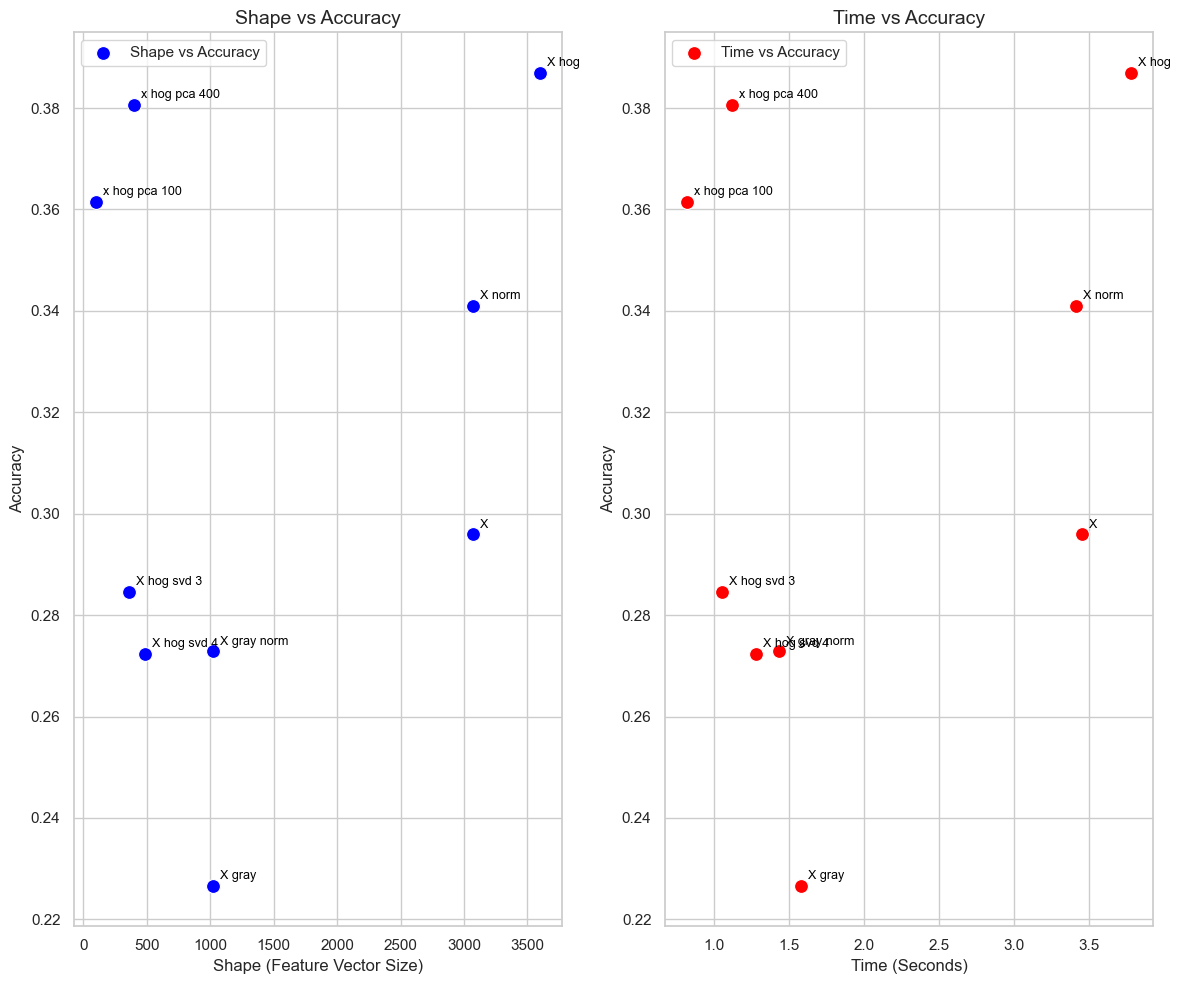

In [28]:
import seaborn as sns


# Set Seaborn style
sns.set(style="whitegrid")

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 10))

# Plot 1: Shape vs Accuracy
sns.scatterplot(x='shape', y='accuracy', data=df, ax=ax1, color='blue', s=100, label='Shape vs Accuracy')
for i in range(len(df)):
    ax1.annotate(df.iloc[i, 0], xy=(df.iloc[i, 1], df.iloc[i, 3]), xytext=(5, 5), textcoords='offset points', fontsize=9, color='black')
ax1.set_xlabel("Shape (Feature Vector Size)", fontsize=12)
ax1.set_ylabel("Accuracy", fontsize=12)
ax1.set_title("Shape vs Accuracy", fontsize=14)
#ax1.legend()

# Plot 2: Time vs Accuracy
sns.scatterplot(x='time', y='accuracy', data=df, ax=ax2, color='red', s=100, label='Time vs Accuracy')
for i in range(len(df)):
    ax2.annotate(df.iloc[i, 0], xy=(df.iloc[i, 2], df.iloc[i, 3]), xytext=(5, 5), textcoords='offset points', fontsize=9, color='black')
ax2.set_xlabel("Time (Seconds)", fontsize=12)
ax2.set_ylabel("Accuracy", fontsize=12)
ax2.set_title("Time vs Accuracy", fontsize=14)
#ax2.legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

First of all, as spected hog SVD didn't performed well.

Based on the results, the dimensionality reduction and preprocessing strategies significantly impact the performance of KNN with HOG features. Among the tested methods, **"X hog pca 400"** stands out as the best option, offering a balanced trade-off between accuracy, feature vector size, and computation time.

- **Accuracy**: "X hog pca 400" achieves nearly the same accuracy as the full HOG features, demonstrating that reducing the dimensionality to 400 dimensions preserves the critical information needed for classification.
- **Feature Vector Size**: It significantly reduces the input size compared to the original HOG features, lowering the dimensionality while retaining high accuracy. This makes it computationally efficient.
- **Computation Time**: With a smaller feature size, the model also achieves one of the lowest computation times, making it a practical choice for real-time or resource-constrained applications.

In conclusion, **"X hog pca 400"** is the optimal approach for image classification in this scenario, as it maintains strong classification performance while reducing dimensionality and computational overhead effectively.

We can't see an example of a reconstruction of the PCA images to see how many information did we loss visually as the input images were already HOG images (5D unhuman data). Although we can see a small example of how it would work in a normal image:

In [115]:
pca = PCA(n_components=600)
pca.fit(X_train_gray)

PCA(n_components=600)

In [121]:
rows, cols = 3, 4
for i in range(3):
    np.random.seed(i)
    flat_img = X_test_gray[np.random.randint(0, len(X_test_gray))]
    img = flat_img.reshape(32, 32)

    plt.subplot(rows,cols,cols*i+1)
    if i == 0: plt.title(f"Original\n({32*32} pixels)")
    plt.axis("off")
    plt.imshow(img)
    pixels = np.linspace(200, 600, cols-1)
    for k in range(cols-1):
        pix = int(pixels[-k-1])
        encoded_flat_img = pca.transform(img.reshape(1, -1))
        encoded_flat_img[:,pix:] = 0    # Reduce the number of pixels without creating a new PCA model.
                                        # This works because PCA outputs features in order, with the most
                                        # significant features at the beginning.
        img_pca = pca.inverse_transform(encoded_flat_img).reshape(32, 32)  
        plt.subplot(rows,cols,cols*i + k+2)
        if i == 0: plt.title(f"PCA encoded\n({pix} pixels)")
        plt.imshow(img_pca)
        plt.axis("off")
plt.show() 

![](img_pca.png)